In [195]:
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
from library.Tempotron import Tempotron
from library.comput_utils import acc_metrics
from library.script_wrappers import find_nidx_along_traj, datagen_jitter
from library.utils import save_pickle, load_pickle
from library.visualization import plot_popras

In [196]:
legendsize = 8
plt.rcParams.update({'font.size': legendsize,
                     "axes.titlesize": legendsize,
                     'axes.labelpad': 0,
                     'axes.titlepad': 0,
                     'xtick.major.pad': 0,
                     'ytick.major.pad': 0,
                     'axes.facecolor': 'w',

                     })
project_tag = 'Jit100_5ms'
simdata_dir = 'sim_results/fig6_TrainStandType-1_ECTrainNoAngle_Whas_exStay_Icompen3'
data_dir = join(simdata_dir, project_tag)
exintag = 'in'
dataset = load_pickle(join(data_dir, 'data_train_test_%s_%s.pickle'%(project_tag, exintag)))
temNw =  np.load(join(data_dir, 'w_%s_%s.npy'%(project_tag, exintag)))
simdata = load_pickle(join(simdata_dir, 'fig6_%s.pkl'%(exintag)))

X_test_ori = dataset['X_test_ori']
Y_test_ori = dataset['Y_test_ori']
trajtype_test_ori = dataset['trajtype_test_ori']
theta_bounds = dataset['theta_bounds']
all_nidx = dataset['all_nidx']
# if exintag == 'ex':
#     dataset = load_pickle(join(data_dir, 'data_train_test_%s_%s.pickle'%(project_tag, 'in')))
X_train_ori = dataset['X_train_ori']
Y_train_ori = dataset['Y_train_ori']
trajtype_train_ori = dataset['trajtype_train_ori']

N = len(X_train_ori[0])
num_trajtypes = trajtype_test_ori.max()+1
trajtype_ax = np.arange(num_trajtypes)
a_ax = trajtype_ax/num_trajtypes*2*np.pi
deg_ax = np.around(np.rad2deg(a_ax), 0).astype(int)

NeuronDF = simdata['NeuronDF']
xxtun1d = NeuronDF['neuronx'].to_numpy()
yytun1d = NeuronDF['neurony'].to_numpy()
aatun1d = NeuronDF['neurona'].to_numpy()

In [197]:
Vthresh = 2
temN_tax = np.arange(0, 100, 1)
temN = Tempotron(N=N, lr=0.01, Vthresh=Vthresh, tau=5, tau_s=5/4, w_seed=0)
temN.w = temNw
Y_train_ori_pred, kout_train_ori, tspout_train_ori = temN.predict(X_train_ori, temN_tax)
Y_test_ori_pred, kout_test_ori, tspout_test_ori = temN.predict(X_test_ori, temN_tax)

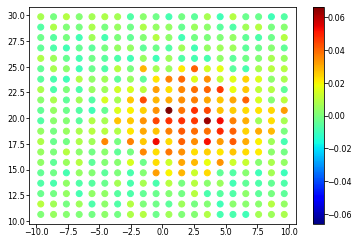

In [198]:
wmin, wmax = temNw.min(), temNw.max()
abswmax = max(np.abs(wmin), np.abs(wmax))
norm = mpl.colors.Normalize(vmin=-abswmax, vmax=abswmax)
val2cmap = cm.ScalarMappable(norm=norm, cmap=cm.jet)
fig, ax = plt.subplots(facecolor='w')
im = ax.scatter(xxtun1d[all_nidx], yytun1d[all_nidx], c=temNw, cmap=cm.jet, vmin=-abswmax, vmax=abswmax)

plt.colorbar(im, ax=ax)
fig.savefig(join(data_dir, 'w_%s_%s.png'%(project_tag, exintag)), dpi=200)

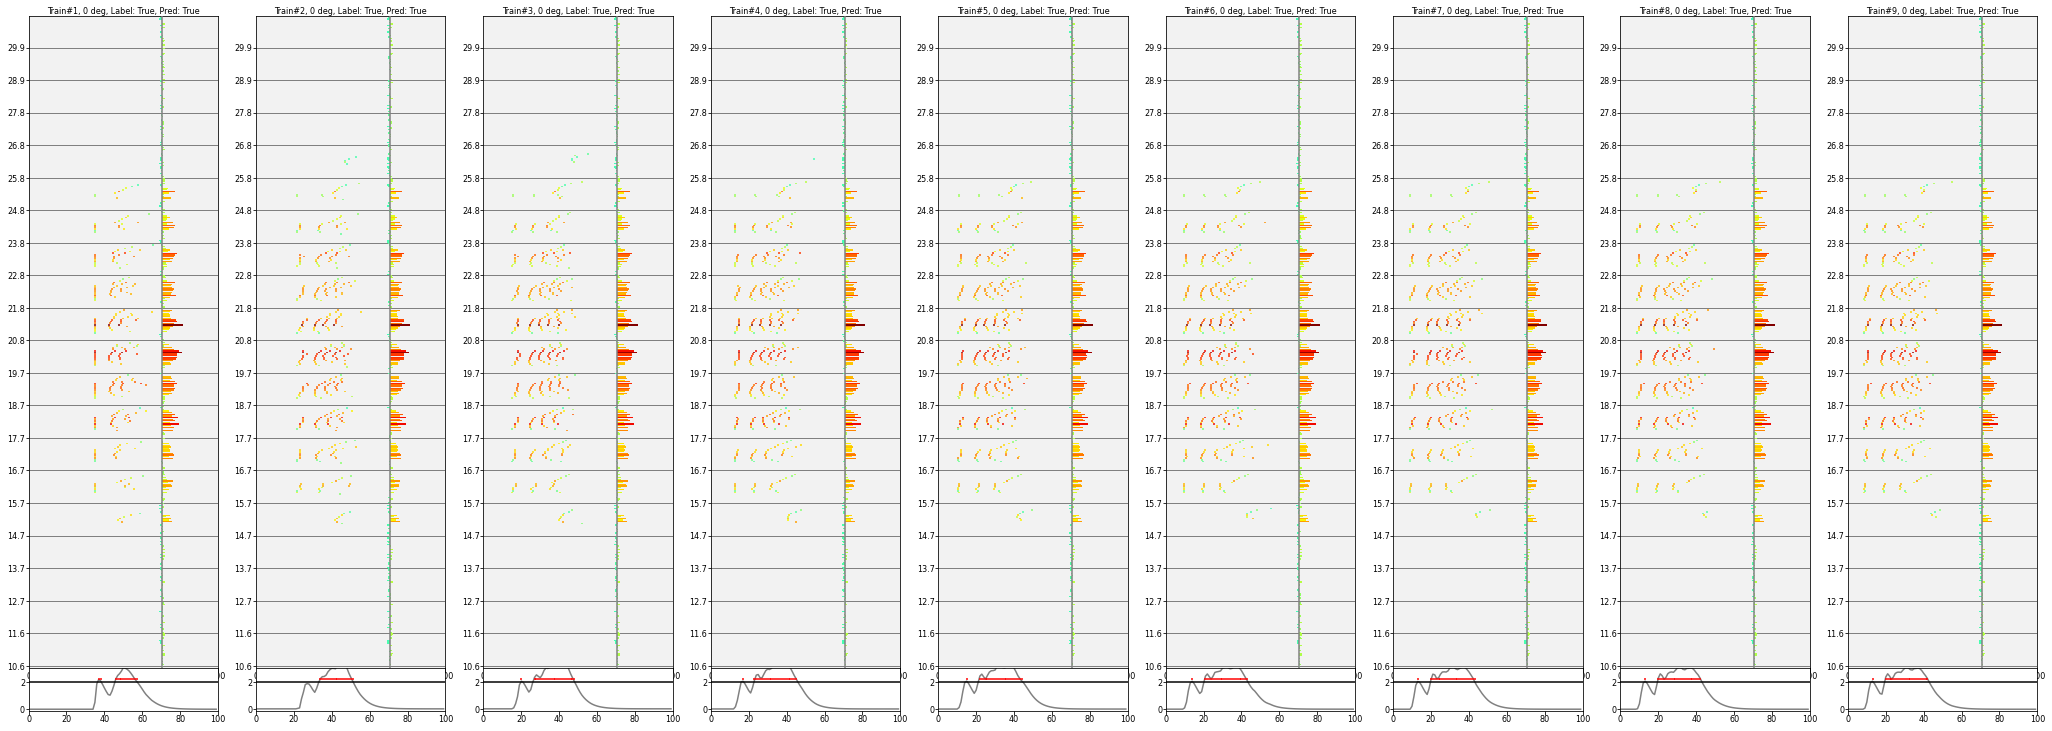

In [199]:
def plot_tempotron_traces(ax, N, X, Y, Y_pred, temNw, all_nidx, yytun1d, kout_all, tspout_all, val2cmap, traj_deg):

    M = ax.shape[0]
    w_yax = np.arange(N)
    for Mi in range(M):

        ysep_NiList = []
        for Ni in range(N):
            tsp = X[Mi, Ni]
            ax[Mi].eventplot(tsp, lineoffsets=Ni, linelengths=1, color=val2cmap.to_rgba(temNw[Ni]))

            if (Ni % 20 ) == 0:
                ax[Mi].axhline(Ni+0.5, linewidth=1, color='gray')
                ysep_NiList.append(Ni)

        ysep_ax = np.array(ysep_NiList) + 0.5
        ax[Mi].set_yticks(ysep_ax)
        ax[Mi].set_yticklabels(np.around(yytun1d[all_nidx[ysep_NiList]], 1).astype(str))
        ax[Mi].set_xlim(0, 100)
        ax[Mi].set_ylim(w_yax.min()-1, w_yax.max()+1)
        ax[Mi].set_title('Train#%d, %d deg, Label: %s, Pred: %s'% (Mi+1, traj_deg, Y[Mi], Y_pred[Mi]))
        if Y[Mi]:
            ax[Mi].set_facecolor('0.95')

        # Plot weights
        left, bottom, width, height = ax[Mi].get_position().bounds
        ax_w = fig.add_axes([left+0.05, bottom, 0.01, height])
        ax_w.barh(w_yax, temNw, color=val2cmap.to_rgba(temNw))
        ax_w.axvline(0, color='gray')
        ax_w.set_yticks(np.around(np.arange(N), 2))
        ax_w.axis('off')
        ax_w.set_ylim(w_yax.min()-1, w_yax.max()+1)

        # Plot voltage trace
        ax_trace_height = 0.05
        ax_trace = fig.add_axes([left, bottom-ax_trace_height, width, ax_trace_height])
        ax_trace.plot(temN_tax, kout_all[Mi], color='gray')
        ax_trace.eventplot(tspout_all[Mi], lineoffsets=2.2, linelengths=0.2, color='r')
        ax_trace.set_xlim(0, 100)
        ax_trace.set_ylim(None, 3)
        ax_trace.axhline(Vthresh, color='k')

fig, ax = plt.subplots(1, 9, figsize=(36, 12), facecolor='w')
plot_tempotron_traces(ax, N, X=X_train_ori, Y=Y_train_ori, Y_pred=Y_train_ori_pred, temNw=temNw, all_nidx=all_nidx,
                      yytun1d=yytun1d, kout_all=kout_train_ori, tspout_all=tspout_train_ori,
                      val2cmap=val2cmap, traj_deg=0)
fig.savefig(join(data_dir, 'AllNeurons_train_%s_%s.png'%(project_tag, exintag)), dpi=200)

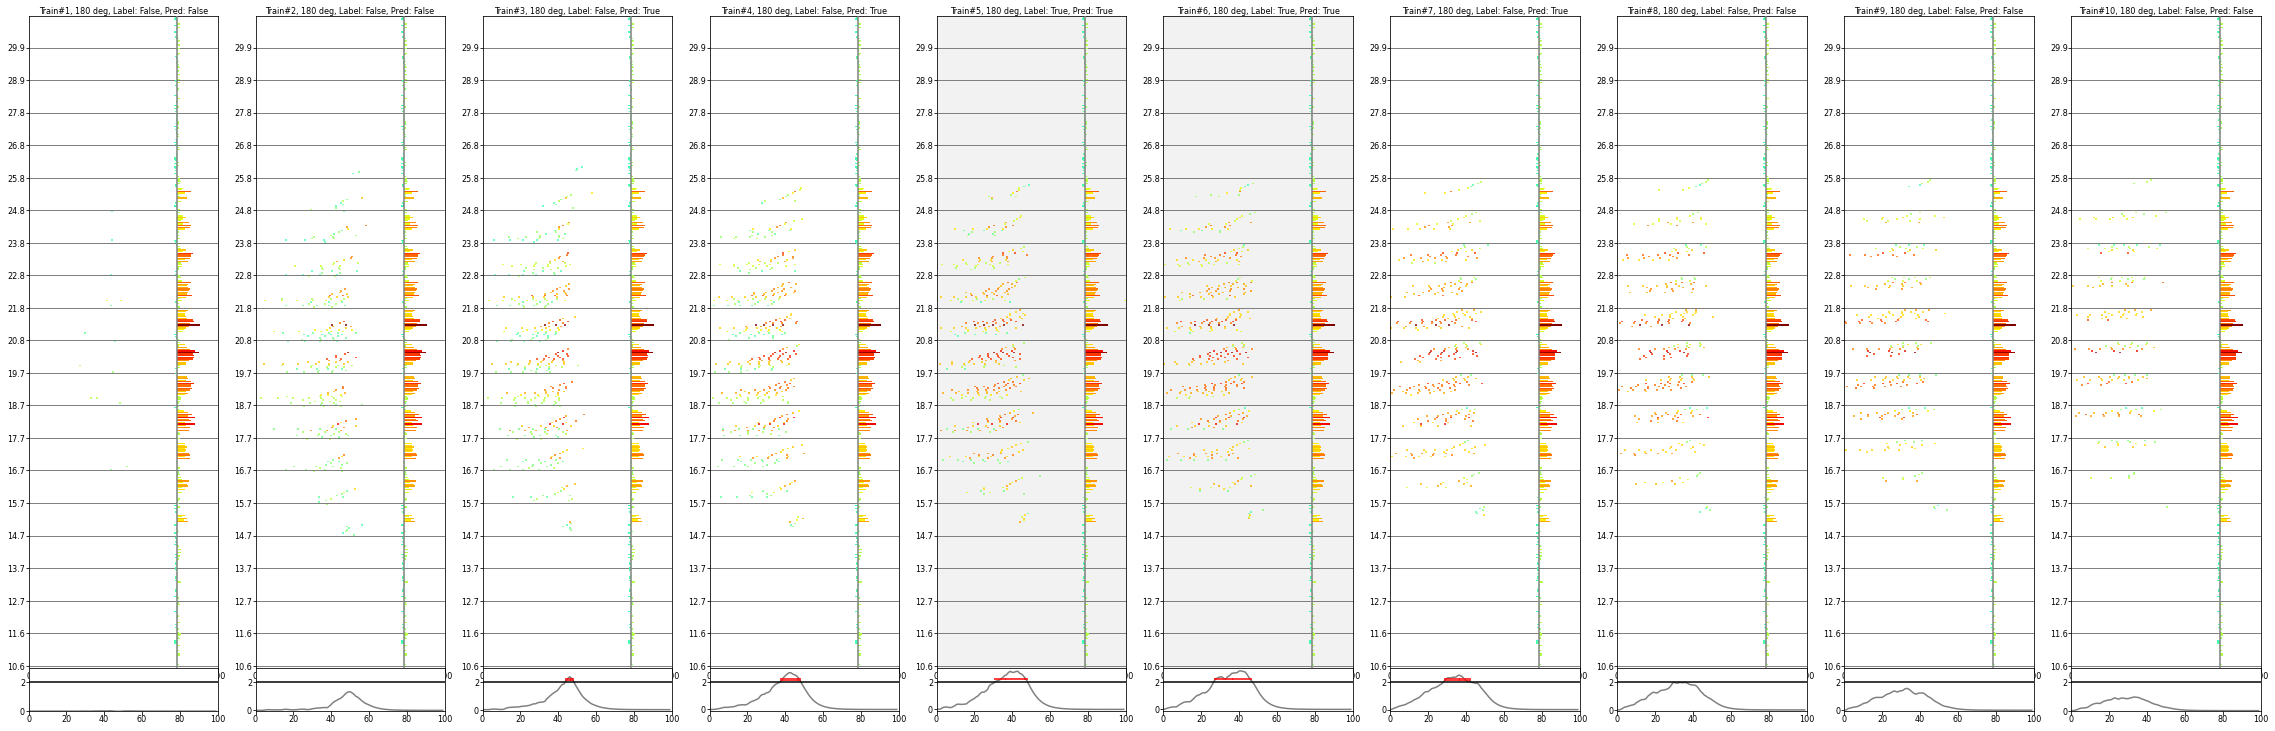

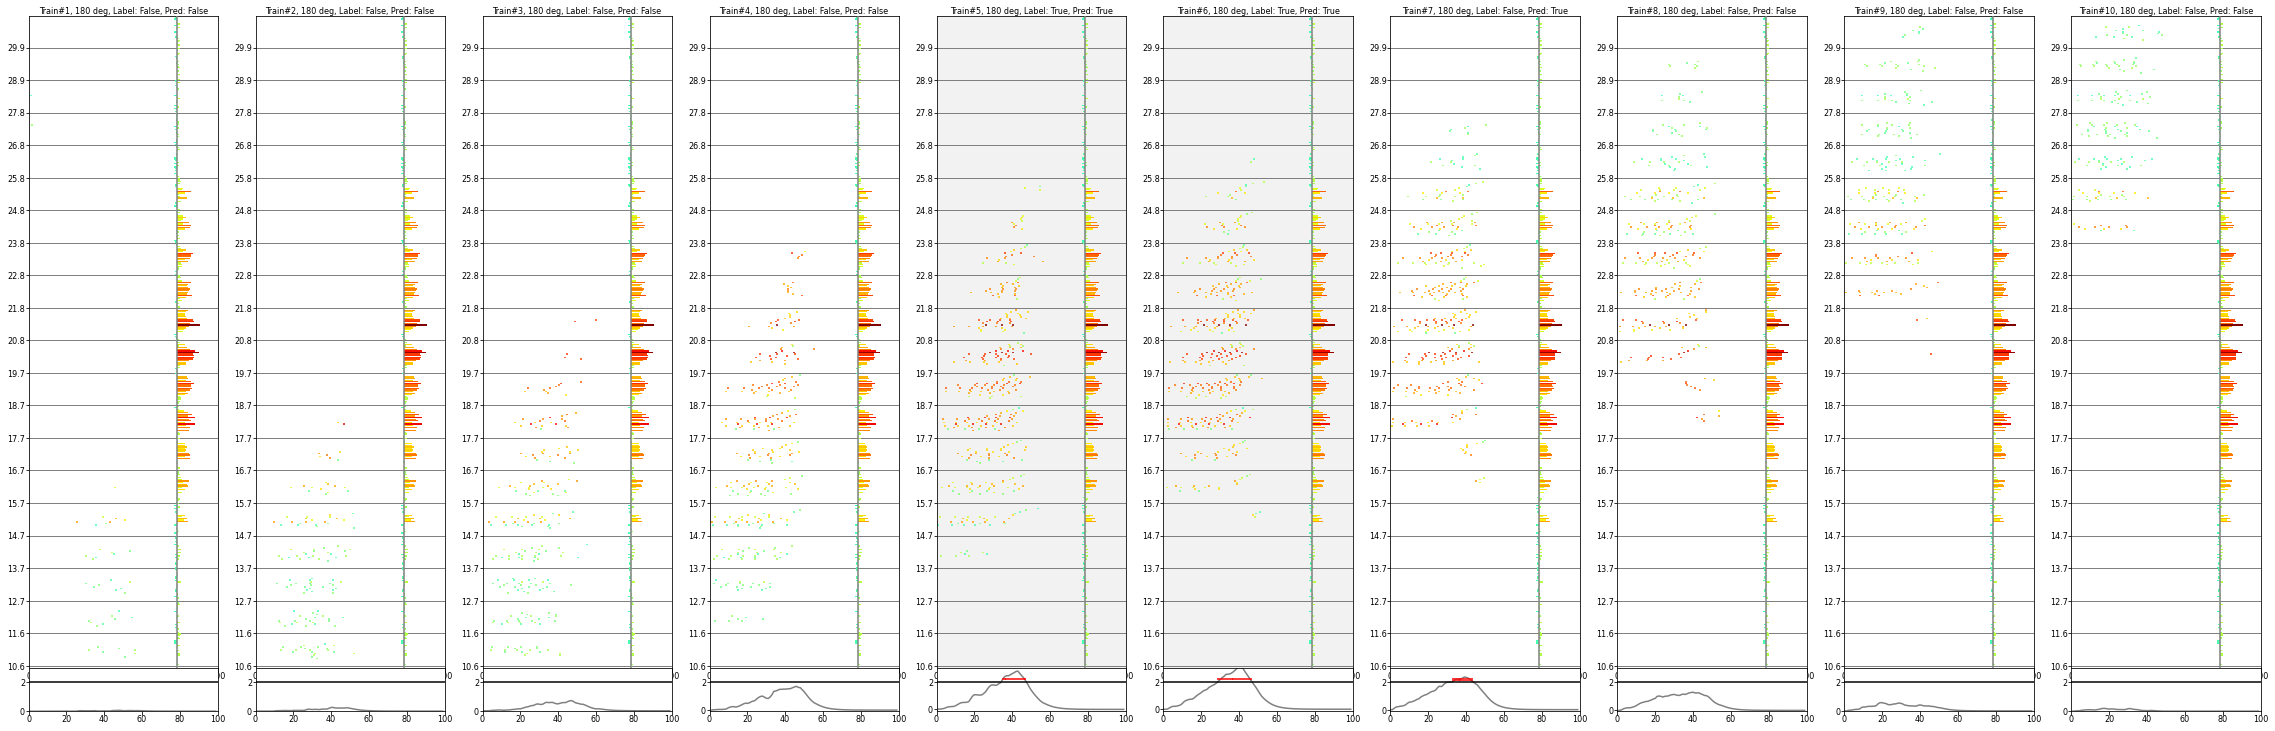

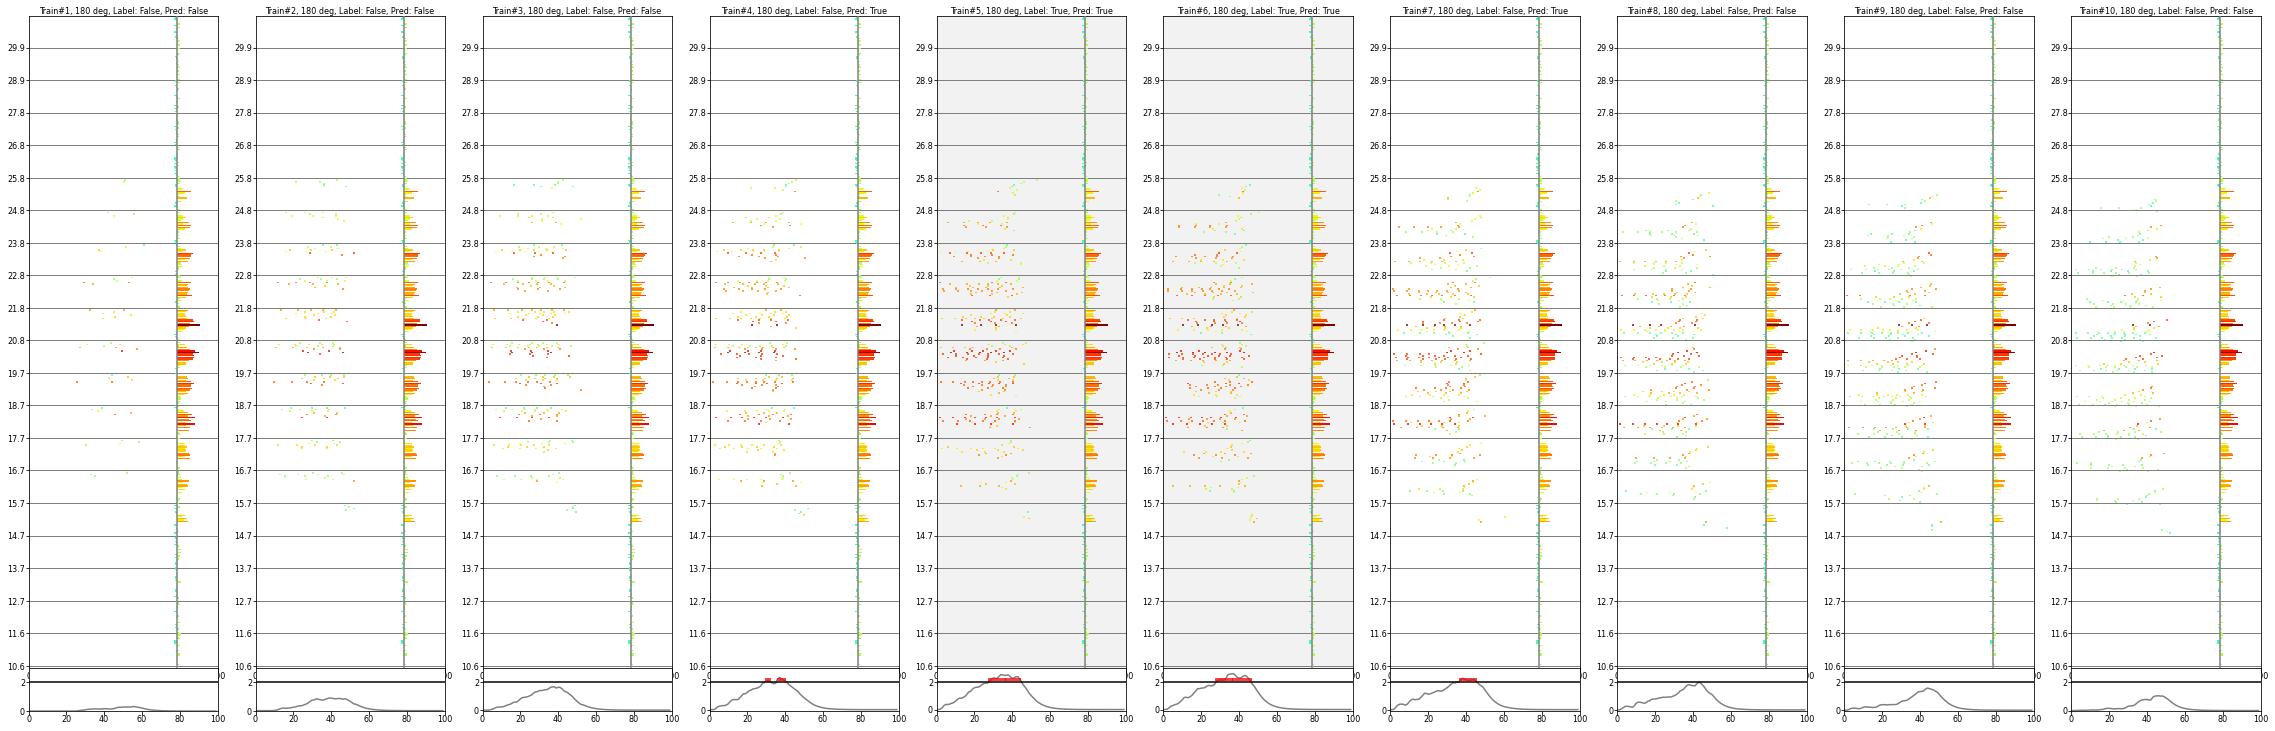

In [200]:
for traj_deg in [0, 90, 180]:

    chosen_trajtype = trajtype_ax[deg_ax==traj_deg].squeeze()
    mask = trajtype_test_ori == chosen_trajtype
    X_test_chosen = X_test_ori[mask]
    Y_test_chosen = Y_test_ori[mask]
    Y_test_ori_pred_chosen = Y_test_ori_pred[mask]
    kout_test_chosen = kout_test_ori[mask]
    tspout_test_chosen = tspout_test_ori[mask]

    fig, ax = plt.subplots(1, 10, figsize=(40, 12), facecolor='w')
    plot_tempotron_traces(ax, N, X=X_test_chosen, Y=Y_test_chosen, Y_pred=Y_test_ori_pred_chosen, temNw=temNw,
                          all_nidx=all_nidx, yytun1d=yytun1d, kout_all=kout_test_chosen, tspout_all=tspout_test_chosen,
                          val2cmap=val2cmap, traj_deg=180)
    fig.savefig(join(data_dir, 'AllNeurons_Test%d_%s_%s.png'%(traj_deg, project_tag, exintag)), dpi=200)


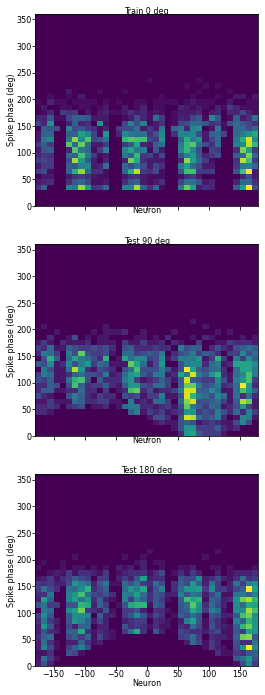

In [201]:
X = X_train_ori

chosen_trajtype = trajtype_ax[deg_ax==90].squeeze()
mask = trajtype_test_ori == chosen_trajtype
X_test_90 = X_test_ori[mask]
chosen_trajtype = trajtype_ax[deg_ax==180].squeeze()
mask = trajtype_test_ori == chosen_trajtype
X_test_180 = X_test_ori[mask]

Xnames = ['Train 0 deg', 'Test 90 deg', 'Test 180 deg']
Xs = [X_train_ori, X_test_90, X_test_180]
fig, ax = plt.subplots(3, 1, figsize=(4, 12), facecolor='w', sharex=True, sharey=True)
bins_phase = np.arange(0, 370, 10)
bins_widx = np.arange(-180, 190, 10)
for Xi in range(3):
    X = Xs[Xi]

    alltsp = []
    allwidx = []

    M = X.shape[0]
    N = X.shape[1]

    for Ni in range(N):
        tsp_allM = []
        for Mi in range(M):

            tsp = X[Mi, Ni]

            tsp_allM.extend(list(tsp))


        alltsp.append(np.asarray(tsp_allM))
        allwidx.append(np.ones(len(tsp_allM)) * aatun1d[all_nidx[Ni]])


    alltsp = np.concatenate(alltsp)
    allphasesp = np.rad2deg(alltsp / 100 * 2 * np.pi)
    allwidx = np.rad2deg(np.concatenate(allwidx))
    #
    ax[Xi].hist2d(allwidx, allphasesp, bins=(bins_widx, bins_phase))
    ax[Xi].set_title(Xnames[Xi])
    ax[Xi].set_xlabel('Neuron')
    ax[Xi].set_ylabel('Spike phase (deg)')

fig.savefig(join(data_dir, 'PhaseVS_Weights_%s_%s.png'%(project_tag, exintag)), dpi=200)